<img src="img/logo-pirelli-dsa.png" align="left"/>
<br>

# Projeção de Produção - Pirelli
***
**Integrantes Grupo:**
<br>Danillo Silva
<br>Diego Dantas
<br>Gustavo Sainatto
<br>Nestor Soken
<br>Rubia Quinteiro Nierotka

## Bibliotecas:
***

In [1]:
#Lista de Packages Utilizados:

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn import metrics

from math import sqrt
from math import pi

from pmdarima.arima import auto_arima

from connection import *
from getShift import *

%matplotlib inline

start_time = pd.Timestamp.today()

### Extração de Dados
***

In [2]:
#Criacao de Variaveis - Periodos de Tempos:

turnos = 3 #n de turnos a ser observado como amostra treino
tempo_turno = 8 * 60

turno_atual = pd.to_datetime(inicio_turno())

turno_passado = turno_atual - dt.timedelta(minutes=(tempo_turno * turnos))

turno_futuro = turno_atual + dt.timedelta(minutes=tempo_turno)

print('Turno Passado: {}'.format(turno_passado))
print('Turno Atual: {}'.format(turno_atual))
print('Turno Futuro: {}'.format(turno_futuro))

Turno Passado: 2019-05-22 23:00:00
Turno Atual: 2019-05-23 23:00:00
Turno Futuro: 2019-05-24 07:00:00


In [3]:
#Query Dataset:

query = open('queries/01_production.sql','r')

df_results = run_queryFS(query.read().format(turno_passado,turno_atual))

### Principais Características do Dataset:
***

In [4]:
#Analise - Dataset Dados Históricos:

print('Dataset Dados Historicos\nObservacoes(Linhas): {}\nVariaveis(Colunas): {}\n'.format(df_results.shape[0],df_results.shape[1]))
print('Principais Variaveis do Dataset: \n')
df_results.info()

df_results.head()

Dataset Dados Historicos
Observacoes(Linhas): 23306
Variaveis(Colunas): 5

Principais Variaveis do Dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23306 entries, 0 to 23305
Data columns (total 5 columns):
MCH_NUMBER      23306 non-null object
EVS_START       23306 non-null datetime64[ns]
EVS_END         23306 non-null datetime64[ns]
MAT_SAP_CODE    12697 non-null object
EVS_REAL_QTY    23306 non-null float64
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 910.5+ KB


,MCH_NUMBER,EVS_START,EVS_END,MAT_SAP_CODE,EVS_REAL_QTY
0,V02,2019-05-23 15:00:20.000,2019-05-23 15:01:33,SAG7263A1,1.0
1,V06,2019-05-23 15:00:31.000,2019-05-23 15:01:47,SAG8151A0,1.0
2,V04,2019-05-23 15:01:18.000,2019-05-23 15:02:42,SAG8957A3,1.0
3,V02,2019-05-23 15:01:34.163,2019-05-23 15:02:50,SAG7263A1,1.0
4,V06,2019-05-23 15:01:49.527,2019-05-23 15:02:57,SAG8151A0,1.0


### Transformar o Dataset em Series Temporais - Maquinas:
***

In [5]:
#Subset Dataset:

df_series = df_results[['EVS_END', 'MCH_NUMBER', 'EVS_REAL_QTY']]
df_series = df_series.groupby(by=['MCH_NUMBER', pd.Grouper(key='EVS_END', freq='5Min')]).sum()

df_series = df_series.unstack('MCH_NUMBER')
df_series.fillna(value=0, inplace=True)

df_series.columns = df_series.columns.droplevel()

df_series.info()
df_series.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2019-05-22 23:00:00 to 2019-05-23 22:55:00
Freq: 5T
Data columns (total 20 columns):
AM1    288 non-null float64
AM2    288 non-null float64
AM3    288 non-null float64
AM4    288 non-null float64
TL1    288 non-null float64
TL2    288 non-null float64
TR1    288 non-null float64
TR2    288 non-null float64
V01    288 non-null float64
V02    288 non-null float64
V03    288 non-null float64
V04    288 non-null float64
V05    288 non-null float64
V06    288 non-null float64
V07    288 non-null float64
V08    288 non-null float64
V09    288 non-null float64
V10    288 non-null float64
V11    288 non-null float64
V12    288 non-null float64
dtypes: float64(20)
memory usage: 47.2 KB


MCH_NUMBER,AM1,AM2,AM3,AM4,TL1,TL2,TR1,TR2,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12
EVS_END,,,,,,,,,,,,,,,,,,,,
2019-05-22 23:00:00,10.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,6.0,4.0,0.0
2019-05-22 23:05:00,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,2.0,0.0,2.0,2.0,4.0,6.0,6.0,4.0
2019-05-22 23:10:00,8.0,0.0,3.0,0.0,0.0,4.0,0.0,1.0,6.0,10.0,8.0,8.0,6.0,0.0,4.0,4.0,2.0,6.0,4.0,6.0
2019-05-22 23:15:00,0.0,0.0,4.0,0.0,1.0,4.0,0.0,2.0,10.0,8.0,8.0,4.0,4.0,4.0,2.0,2.0,2.0,6.0,4.0,4.0
2019-05-22 23:20:00,4.0,0.0,2.0,0.0,0.0,4.0,0.0,2.0,8.0,8.0,8.0,0.0,0.0,2.0,4.0,4.0,2.0,4.0,4.0,4.0


C:\Users\silvada010\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


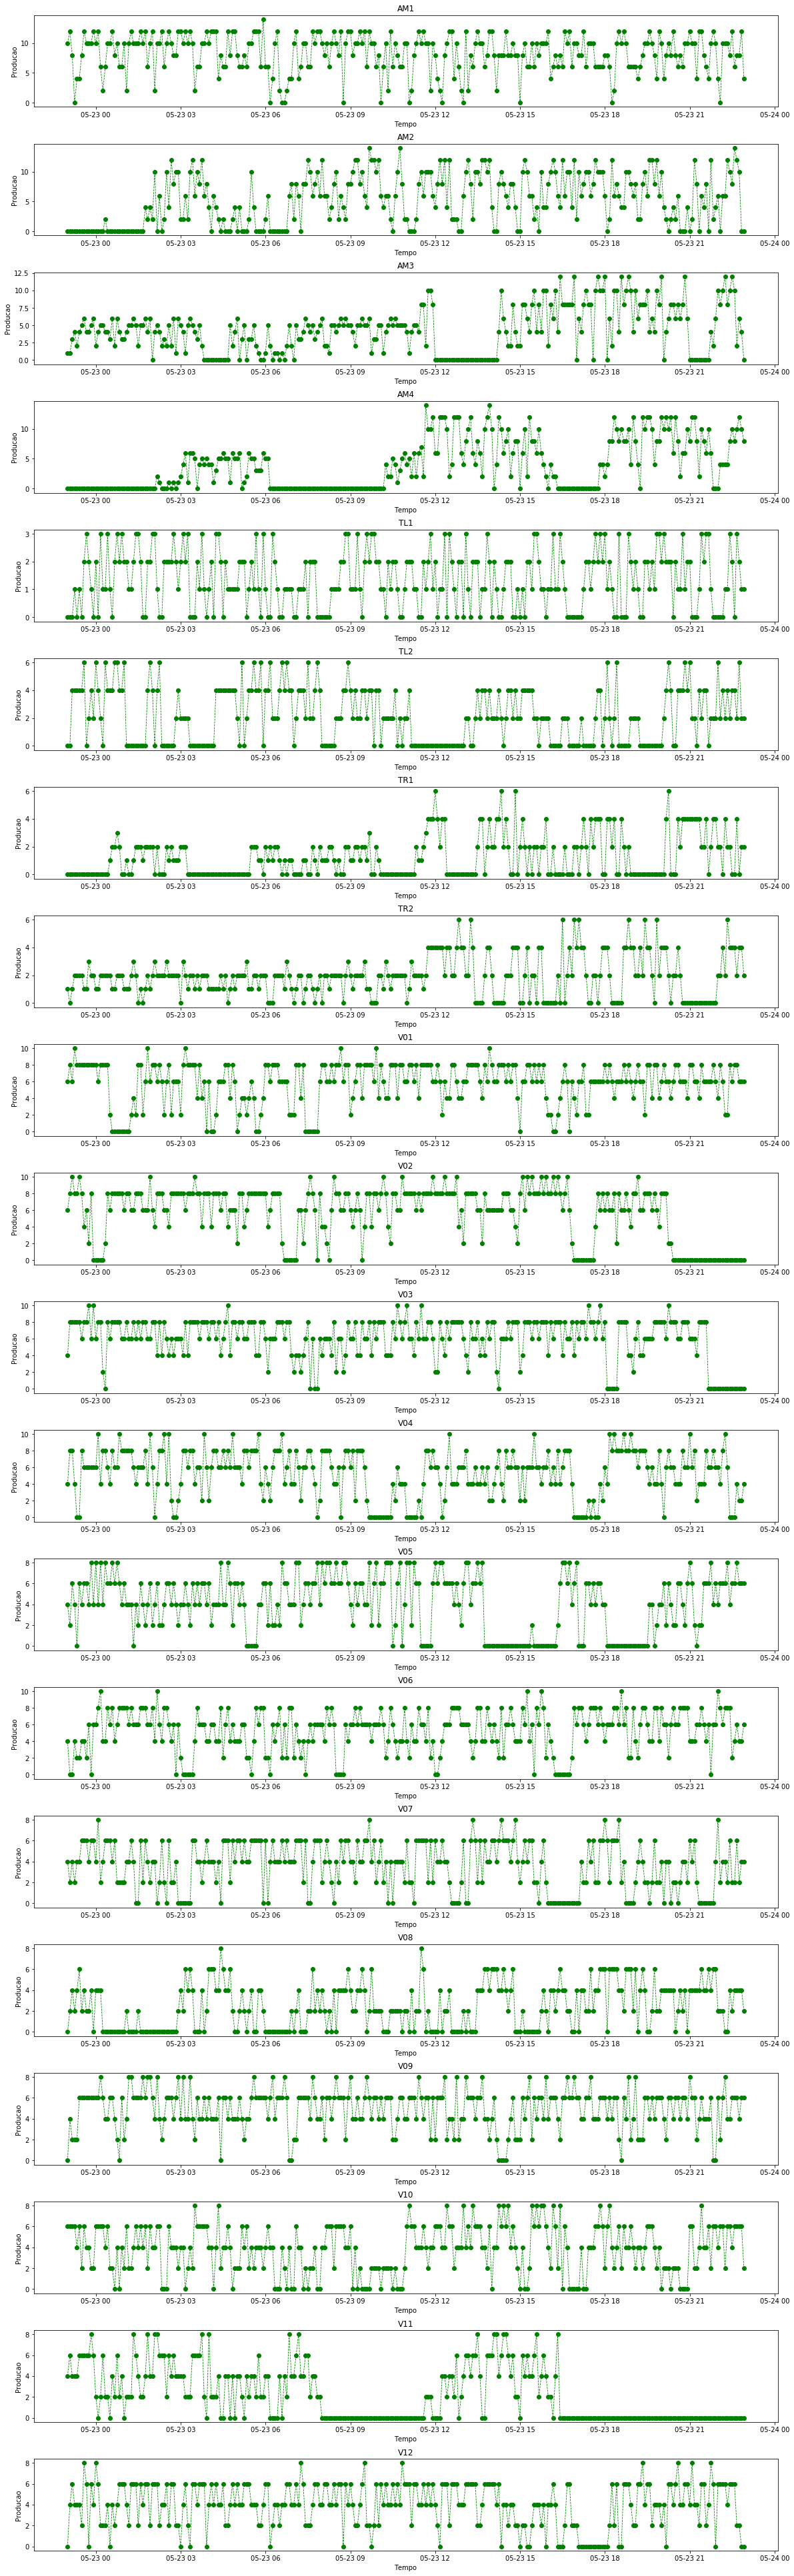

In [6]:
#Plot Series por Máquina:

fig, ax = plt.subplots(nrows=df_series.columns.size,ncols=1, figsize=(20,70))
fig.subplots_adjust(hspace =.4, wspace=.4)

for i in range(df_series.columns.size):
    ax[i].plot(df_series.index, df_series[df_series.columns[i]], color='green', marker='o', linestyle='dashed', linewidth = 0.8)
    
    ax[i].set_title(str(df_series.columns[i]))
    ax[i].set_xlabel('Tempo')
    ax[i].set_ylabel('Producao')

### Verificar Estacionaridade da Serie Temporal
***

In [7]:
#Testar Estacionaridade da Série Temporal através do Test Augmented Dickey-Fuller Test (ADF):

adf = dict(zip(df_series.columns.tolist(),
               [True if (adfuller(df_series[col])[1] < 0.05) else False for col in df_series.columns.tolist()]))
print(adf)

{'AM1': True, 'AM2': True, 'AM3': True, 'AM4': False, 'TL1': True, 'TL2': True, 'TR1': True, 'TR2': True, 'V01': True, 'V02': True, 'V03': True, 'V04': True, 'V05': True, 'V06': True, 'V07': True, 'V08': True, 'V09': True, 'V10': True, 'V11': False, 'V12': True}


### Calcular AUTO ARIMA para cada o Dataset Treino de cada Máquina:
***

In [8]:
#Criar um Dataset com os resultados do Treinamento para o Periodo Treino:

model ={}
for i in range(df_series.columns.size):
    maq = df_series.columns[i]
    print(str(maq) + ' - Modelo AUTO ARIMA:')
    
    arima_model = auto_arima(df_series[maq], seasonal=True, stationary=adf[maq],trace=True,
                             error_action='ignore',suppress_warnings=True, stepwise=True)
    
    score = np.array(arima_model.predict_in_sample())
    true = np.array(df_series[maq].values)
    
    score_tot = float(score.sum())
    true_tot = float(true.sum())
    
    acc = round((100 - abs((score_tot / true_tot)-1)*100) , 3)
    
    rmse = sqrt(metrics.mean_squared_error(true,score))
            
    model[maq] = [arima_model, score, true, acc, rmse]

df_model =  pd.DataFrame.from_dict(model, orient='index', columns=['model','score','true', 'acc','rmse'])

AM1 - Modelo AUTO ARIMA:
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1496.027, BIC=1518.005, Fit time=0.368 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1505.648, BIC=1512.974, Fit time=0.008 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1491.650, BIC=1502.639, Fit time=0.049 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1492.878, BIC=1503.867, Fit time=0.044 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1493.649, BIC=1508.301, Fit time=0.079 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1493.649, BIC=1508.301, Fit time=0.077 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1493.982, BIC=1512.297, Fit time=0.359 seconds
Total fit time: 0.985 seconds
AM2 - Modelo AUTO ARIMA:
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1561.750, BIC=1583.727, Fit time=0.265 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1663

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1289.501, BIC=1311.478, Fit time=0.195 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1365.418, BIC=1372.744, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1290.254, BIC=1301.242, Fit time=0.035 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1309.222, BIC=1320.211, Fit time=0.041 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1288.365, BIC=1306.679, Fit time=0.127 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1286.743, BIC=1301.395, Fit time=0.079 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1288.540, BIC=1306.855, Fit time=0.187 seconds
Total fit time: 0.677 seconds
V02 - Modelo AUTO ARIMA:
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1274.838, BIC=1296.816, Fit time=0.150 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1497.742, BIC=1505.068, Fit t

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1254.919, BIC=1269.571, Fit time=0.143 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1255.490, BIC=1273.805, Fit time=0.183 seconds
Total fit time: 0.776 seconds
V11 - Modelo AUTO ARIMA:
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1159.053, BIC=1181.010, Fit time=0.211 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1243.951, BIC=1251.270, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1201.236, BIC=1212.215, Fit time=0.032 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1158.149, BIC=1169.127, Fit time=0.054 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1155.938, BIC=1170.576, Fit time=0.102 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1157.823, BIC=1176.120, Fit time=0.181 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan se

In [9]:
#Mostrar Tabela de Resultados do Modelo:

df_model

,model,score,true,acc,rmse
AM1,"ARIMA(callback=None, disp=0, maxiter=None, met...","[8.261311803152639, 8.666180581976597, 9.13189...","[10.0, 12.0, 8.0, 0.0, 4.0, 4.0, 8.0, 12.0, 10...",99.982,3.190717
AM2,"ARIMA(callback=None, disp=0, maxiter=None, met...","[4.99290708737108, 2.2806915270253834, 1.96223...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",98.661,3.549169
AM3,"ARIMA(callback=None, disp=0, maxiter=None, met...","[4.1962777427378155, 2.4293955282342283, 2.033...","[1.0, 1.0, 3.0, 4.0, 2.0, 4.0, 5.0, 6.0, 4.0, ...",99.515,2.634206
AM4,"ARIMA(callback=None, disp=0, maxiter=None, met...","[0.031345698305453765, 0.031345783606130245, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",99.981,2.597109
TL1,"ARIMA(callback=None, disp=0, maxiter=None, met...","[1.3417745721467158, 1.004258164080732, 1.0042...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 3.0, ...",99.912,1.009103
TL2,"ARIMA(callback=None, disp=0, maxiter=None, met...","[2.1282875458104673, 1.140585321158593, 0.9240...","[0.0, 0.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 0.0, ...",99.685,1.715242
TR1,"ARIMA(callback=None, disp=0, maxiter=None, met...","[1.2238998287382432, 0.6392714738898961, 0.548...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",99.436,1.247193
TR2,"ARIMA(callback=None, disp=0, maxiter=None, met...","[1.8881511413169771, 1.4719415152561304, 1.002...","[1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, ...",99.842,1.275573
V01,"ARIMA(callback=None, disp=0, maxiter=None, met...","[5.750393312855403, 5.870341796878589, 6.71336...","[6.0, 8.0, 6.0, 10.0, 8.0, 8.0, 8.0, 8.0, 8.0,...",99.959,2.226891
V02,"ARIMA(callback=None, disp=0, maxiter=None, met...","[5.559249047342886, 5.878456516133789, 6.99515...","[6.0, 8.0, 10.0, 8.0, 8.0, 10.0, 8.0, 4.0, 6.0...",99.875,2.168777


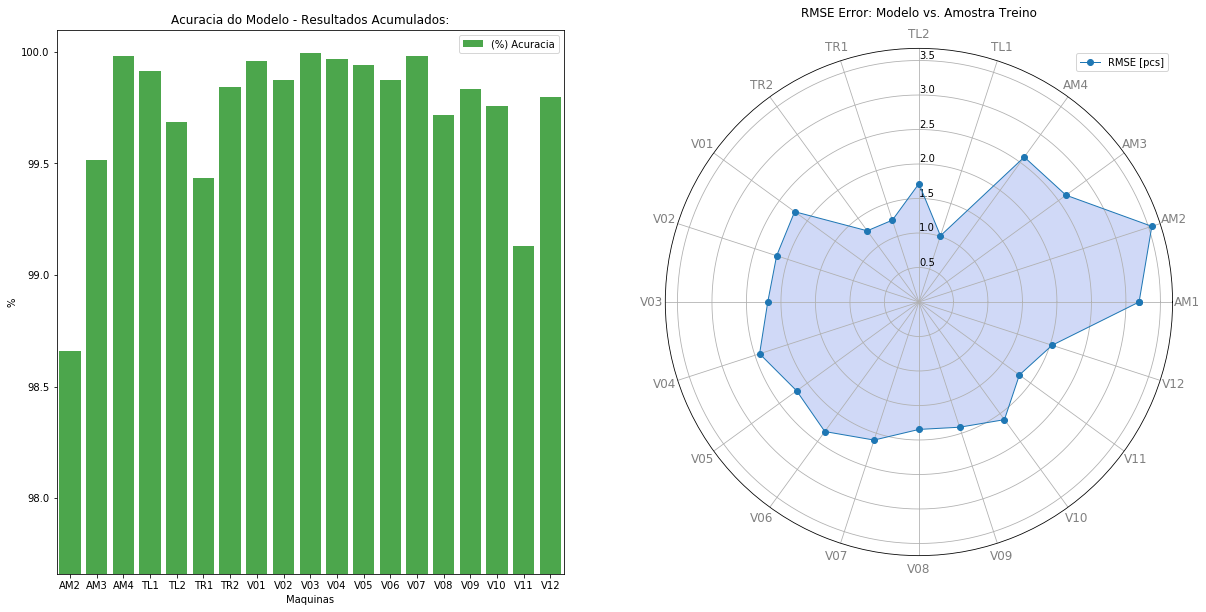

In [14]:
#Plot Gráficos de Resultados e RMSE - Período Acumulado:

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
fig.subplots_adjust(hspace =.2, wspace=.2)

#Grafico Acuracia:

_= ax[0].bar(df_model.index, df_model['acc'],linewidth=.8, alpha = 0.7, color='green')

_= ax[0].set_ylim((df_model['acc'].min()-1),(df_model['acc'].max()+0.1))
_= ax[0].set_xlim(0.5,df_model.index.size-0.5)

_= ax[0].set_title('Acuracia do Modelo - Resultados Acumulados:')
_= ax[0].set_xlabel('Maquinas')
_= ax[0].set_ylabel('%')
_= ax[0].legend(['(%) Acuracia'],loc='best')


#Grafico RMSE:

angles = [n / float(df_model.index.size) * 2 * pi for n in range(df_model.index.size)]
angles += angles[:1]

values= values = list(df_model['rmse'])
values += values[:1]

ax = plt.subplot(122, polar=True)
_= plt.xticks(angles[:-1], df_model.index.tolist(), color='grey', size=12)

_= ax.set_rlabel_position(90)

_= ax.plot(angles, values, linewidth=1, marker='o', linestyle='solid', label='RMSE [pcs]')
_= ax.fill(angles, values, 'b', alpha=0.1)

_= ax.fill(angles, values, alpha=0.1)

_= ax.set_title('RMSE Error: Modelo vs. Amostra Treino')
_= ax.legend(loc='best')

plt.savefig('rmse_1dia_ex.png')

### Projetar Periodo Futuro com Dados do Modelo por Máquina
***

In [11]:
#Criar Projecoes por Máquina:

intervalo = pd.date_range(start= turno_atual, end= turno_futuro, freq='5Min')

pred = {}
for i in range(df_model.shape[0]):
    pred[df_model.index[i]] = df_model['model'][i].predict(n_periods=intervalo.size)

df_forecast =  pd.DataFrame.from_dict(pred)
df_forecast.index = intervalo

df_forecast.info()

df_forecast.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97 entries, 2019-05-23 23:00:00 to 2019-05-24 07:00:00
Freq: 5T
Data columns (total 20 columns):
AM1    97 non-null float64
AM2    97 non-null float64
AM3    97 non-null float64
AM4    97 non-null float64
TL1    97 non-null float64
TL2    97 non-null float64
TR1    97 non-null float64
TR2    97 non-null float64
V01    97 non-null float64
V02    97 non-null float64
V03    97 non-null float64
V04    97 non-null float64
V05    97 non-null float64
V06    97 non-null float64
V07    97 non-null float64
V08    97 non-null float64
V09    97 non-null float64
V10    97 non-null float64
V11    97 non-null float64
V12    97 non-null float64
dtypes: float64(20)
memory usage: 15.9 KB


,AM1,AM2,AM3,AM4,TL1,TL2,TR1,TR2,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12
2019-05-23 23:00:00,7.269028,3.799191,3.266198,8.635224,1.255803,2.346090,1.489502,1.985348,5.924786,0.987886,1.758793,4.312075,5.571109,5.276123,3.682335,2.763357,5.194018,3.778580,-0.063710,2.894298
2019-05-23 23:05:00,8.030250,4.928745,3.358378,9.031059,1.320149,2.299262,1.199842,2.250590,5.873835,1.498112,2.344946,4.678417,5.363034,5.237975,3.656010,2.704595,5.094861,3.777802,-0.088813,3.436177
2019-05-23 23:10:00,8.207507,5.254469,3.441423,9.061886,1.336335,2.262502,1.729841,1.775360,5.837770,1.951390,2.848163,4.881166,5.183709,5.212648,3.635179,2.655400,5.030969,3.777206,-0.107117,3.467920
2019-05-23 23:15:00,8.248783,5.338661,3.516237,9.049207,1.340406,2.233645,1.311633,2.124387,5.812242,2.354076,3.280180,5.014996,5.029161,5.195833,3.618695,2.614215,4.989800,3.776749,-0.124223,3.497616
2019-05-23 23:20:00,8.258394,5.350753,3.583636,9.071888,1.341430,2.210993,1.415366,1.783656,5.794172,2.711817,3.651070,5.098971,4.895967,5.184670,3.605651,2.579735,4.963273,3.776400,-0.141118,3.525398


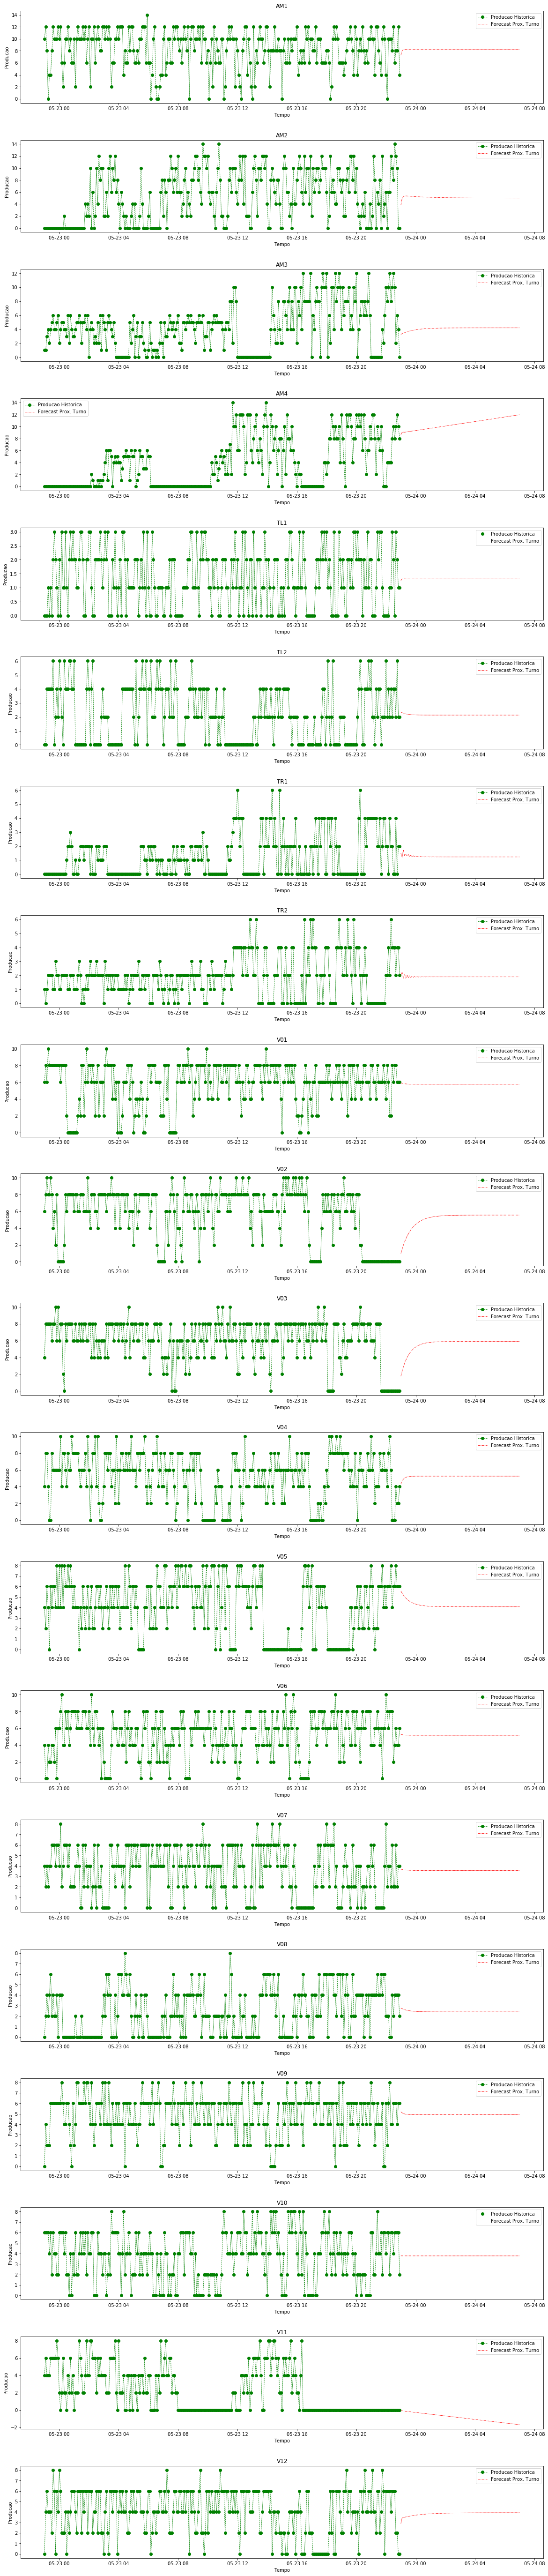

In [15]:
#Plot Graficos de Dataset Treino + Projecao:

fig, ax = plt.subplots(nrows=df_series.columns.size,ncols=1, figsize=(20,100))
fig.subplots_adjust(hspace =.4, wspace=.4)

for i in range(df_series.columns.size):
    ax[i].plot(df_series.index, df_series[df_series.columns[i]], color='green', marker='o', linestyle='dashed', linewidth = 0.8, label='Producao Historica')
    ax[i].plot(df_forecast.index,df_forecast[df_forecast.columns[i]], color='red', linestyle='dashdot', linewidth = 0.8, label='Forecast Prox. Turno')
    
    ax[i].set_title(str(df_series.columns[i]))
    ax[i].set_xlabel('Tempo')
    ax[i].set_ylabel('Producao')
    ax[i].legend(loc='best')

plt.savefig('projecao_ex_1dia.png')

In [13]:
end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Executed in: 0 days 00:00:59.490608
